Test the new pcolormesh algorithm

In [47]:
from datetime import datetime
import timeit
import operator

import matplotlib.pyplot as plt
import numpy as np
import asilib.map
import asilib
from asilib.asi.trex import trex_rgb

Current implementation

Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


/home/mike/research/asilib/env_212/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


plot_map time 2.09


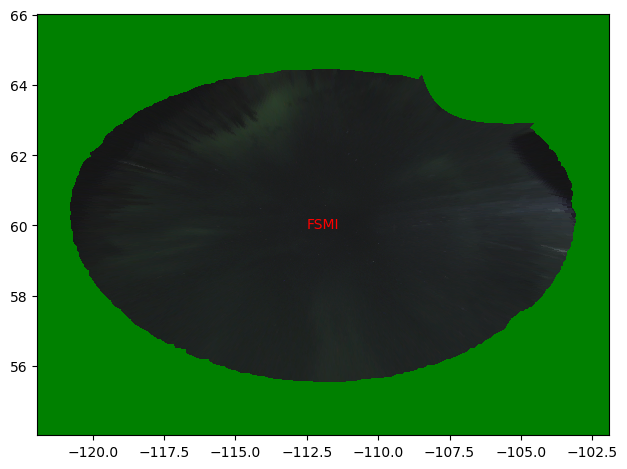

In [4]:
time = datetime(2021, 11, 4, 7, 3, 51)
asi = trex_rgb('FSMI', time=time)
ax = asilib.map.create_simple_map(
    lon_bounds=(asi.meta['lon']-10, asi.meta['lon']+10),
    lat_bounds=(asi.meta['lat']-6, asi.meta['lat']+6)
)
start = timeit.default_timer()
asi.plot_map(ax=ax)
print(f'plot_map time {timeit.default_timer()-start:.2f}')
plt.tight_layout()

New implementation

In [5]:
class Clean_Skymap:
    def __init__(self, lon_grid, lat_grid, el_grid, min_elevation=None):
        """
        Clean the skymap by applying two steps: 1) Mask the lon_grid and lat_grid
        variables with np.nan if they are below min_elevation, and 2) replace all
        np.nan values in lon_grid, lat_grid with the closest valid value.
        """
        # Copy variables to not modify original np.arrays.
        self._lon_grid = lon_grid.copy()
        self._lat_grid = lat_grid.copy()
        self._el_grid = el_grid
        self.min_elevation = min_elevation
        if self.min_elevation is not None:
            self._mask_elevation()
        return
    
    def _mask_elevation(self):
        """
        Mask low elevation pixels.
        """
        if self._el_grid.shape == self._lon_grid.shape:
            _el_grid = self._el_grid.copy()
        elif (self._el_grid.shape[0]+1 == self._lon_grid.shape[0]) and (self._el_grid.shape[1]+1 == self._lon_grid.shape[1]):
            # If the lat/lon grid is defined at pixel vertices while the el grid defines the pixel centers.
            # Here we will pretend that the el_grid is defined at pixel vertices by appending one row and column
            _el_grid = self._el_grid.copy()
            _el_grid = np.concatenate((_el_grid, _el_grid[-1, :].reshape(1, _el_grid.shape[1])), axis=0)
            _el_grid = np.concatenate((_el_grid, _el_grid[:, -1].reshape(_el_grid.shape[0], 1)), axis=1)
        else:
            raise ValueError(
                f'Can not apply elevation mask to lat/lon skymap with shape {self._lon_grid.shape} and'
                f'the elevation skymap shape {self._el_grid.shape}. The shapes must be equal or the '
                f'elevation skymap must be one less than the lon_grid.'
                )
        idh = np.where(np.isnan(_el_grid) | (_el_grid < self.min_elevation))
        self._lon_grid[idh] = np.nan
        self._lat_grid[idh] = np.nan
        return

    def remove_nans(self, ax=None):
        """
        Since pcolormesh can't handle any nan values in the x or y arrays,
        this algorithm removes them. It loops over grid angle pairs 
        (e.g. (0, 10), (10, 20), ...), finds the points in x & y that are
        between those angles, and reassigns those invalid values to the 
        valid point with the lowest elevation in that segment.
        """
        if np.all(np.isfinite(self._lon_grid)) and np.all(np.isfinite(self._lat_grid)):
            return self._lon_grid, self._lat_grid
            
        center_index = np.unravel_index(np.nanargmax(self._el_grid), self._el_grid.shape)

        if ax is None:
            num=100
        else:
            num=ax.shape[0]*ax.shape[1]

        angles = np.linspace(0, 2*np.pi, num=num)
        # We need to set up 2 sets of grids since U Calgary's (lat, lon) skymap
        # dimentions are 1 greater than the (elevation, azimuth) skymaps.
        xx_geodetic, yy_geodetic = np.meshgrid(
            np.arange(self._lon_grid.shape[0]), 
            np.arange(self._lon_grid.shape[1]), 
            indexing='ij'  # So that the shapes of x, y, xx, and yy are the same.
            )
        xx_elevation, yy_elevation = np.meshgrid(
            np.arange(self._el_grid.shape[0]), 
            np.arange(self._el_grid.shape[1]), 
            indexing='ij'  # So that the shapes of x, y, xx, and yy are the same.
            )
        
        for i, (start_angle, end_angle) in enumerate(zip(angles[:-1], angles[1:])):
            # These if-else blocks are probably causing the angular sliver bug which is 
            # patched below.
            if (start_angle < np.pi/2) or (start_angle > 3*np.pi/2):
                start_slope_sign = 1
            else:
                start_slope_sign = -1
            if (end_angle < np.pi/2) or (end_angle > 3*np.pi/2):
                end_slope_sign = 1
            else:
                end_slope_sign = -1
            # start_slope_sign = 1
            # end_slope_sign = 1
    
            start_slope = start_slope_sign*np.tan(start_angle)
            start_y_int = center_index[1] - start_slope*center_index[0]
            end_slope = end_slope_sign*np.tan(end_angle)
            end_y_int = center_index[1] - end_slope*center_index[0]

            geodetic_slice_invalid_indices = np.where(
                    (yy_geodetic >= start_slope*xx_geodetic + start_y_int) &
                    (yy_geodetic <= end_slope*xx_geodetic + end_y_int) &
                    (np.isnan(self._lon_grid) | np.isnan(self._lat_grid))
                )

            if self._lat_grid.shape == self._el_grid.shape:
                elevation_slice_valid_indices = np.where(
                    (yy_elevation > start_slope*xx_elevation + start_y_int) &
                    (yy_elevation < end_slope*xx_elevation + end_y_int) &
                    np.isfinite(self._el_grid) & 
                    np.isfinite(self._lon_grid) &
                    np.isfinite(self._lat_grid)
                )
            else:
                elevation_slice_valid_indices = np.where(
                    (yy_elevation > start_slope*xx_elevation + start_y_int) &
                    (yy_elevation < end_slope*xx_elevation + end_y_int) &
                    np.isfinite(self._el_grid) & 
                    np.isfinite(self._lon_grid[:-1, :-1]) &
                    np.isfinite(self._lat_grid[:-1, :-1])
                )
            min_el_slice_index = np.argmin(self._el_grid[elevation_slice_valid_indices])
            self._lon_grid[geodetic_slice_invalid_indices] = self._lon_grid[
                elevation_slice_valid_indices[0][min_el_slice_index],
                elevation_slice_valid_indices[1][min_el_slice_index]
                ]
            self._lat_grid[geodetic_slice_invalid_indices] = self._lat_grid[
                elevation_slice_valid_indices[0][min_el_slice_index],
                elevation_slice_valid_indices[1][min_el_slice_index]
                ]
            
            if ax is not None:
                test_image = np.zeros_like(xx_geodetic)
                test_image[elevation_slice_valid_indices] = 1
                test_image[geodetic_slice_invalid_indices] = 0.5
                row = i // ax.shape[1]
                col = i % ax.shape[1]
                ax[row, col].pcolormesh(xx_geodetic, yy_geodetic, test_image)
                ax[row, col].plot(xx_geodetic[:, 0], xx_geodetic[:, 0]*start_slope+start_y_int, c='g')
                ax[row, col].plot(xx_geodetic[:, 0], xx_geodetic[:, 0]*end_slope+end_y_int, c='r')
                ax[row, col].set_xlim(xx_geodetic.min(), xx_geodetic.max())
                ax[row, col].set_ylim(yy_geodetic.min(), yy_geodetic.max())
                ax[row, col].set_title(f'{round(np.rad2deg(start_angle))} {round(np.rad2deg(end_angle))}')

        # # The following section is a patch for the small angular sliver of points
        # # that the method misses. I am trying a quick and dirty approach first to determine 
        # # if this approach even works.
        # invalid_idxs = np.where(np.isnan(self._lon_grid) | np.isnan(self._lat_grid))
        # valid_indices = np.where(np.isfinite(self._lon_grid) & np.isfinite(self._lat_grid))
        # for invalid_idx in zip(*invalid_idxs):
        #     min_valid_idx_flattened = np.nanargmin(
        #         (invalid_idx[0]-xx_geodetic[valid_indices])**2 + (invalid_idx[1]-yy_geodetic[valid_indices])**2
        #         )
        #     closest_valid_idx = (
        #         valid_indices[0][min_valid_idx_flattened], 
        #         valid_indices[1][min_valid_idx_flattened]
        #         )
        #     self._lat_grid[invalid_idx] = self._lat_grid[closest_valid_idx]
        #     self._lon_grid[invalid_idx] = self._lon_grid[closest_valid_idx]
        
        # TODO: Uncomment following if block when done.        
        # if np.any(~np.isfinite(self._lon_grid)) or np.any(~np.isfinite(self._lat_grid)):
        #     raise ValueError(
        #         'Either the lat or lon skymap still contains invalid values '
        #         '(nans are not allowed).'
        #         )
        return self._lon_grid, self._lat_grid


55.439632 64.44471


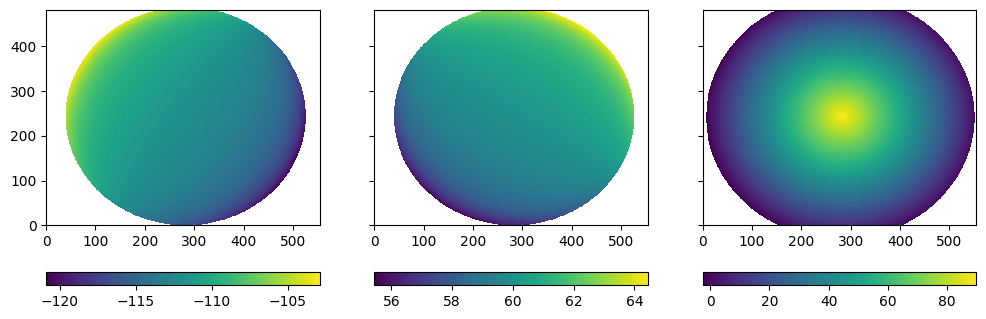

In [6]:
skymap_cleaner = Clean_Skymap(asi.skymap['lon'], asi.skymap['lat'], asi.skymap['el'], min_elevation=10)
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4))
p0 = ax[0].pcolormesh(skymap_cleaner._lon_grid)
plt.colorbar(p0, orientation='horizontal')
p = ax[1].pcolormesh(skymap_cleaner._lat_grid)
plt.colorbar(p, orientation='horizontal')
p = ax[2].pcolormesh(skymap_cleaner._el_grid)
plt.colorbar(p, orientation='horizontal')

print(np.nanmin(skymap_cleaner._lat_grid), np.nanmax(skymap_cleaner._lat_grid))

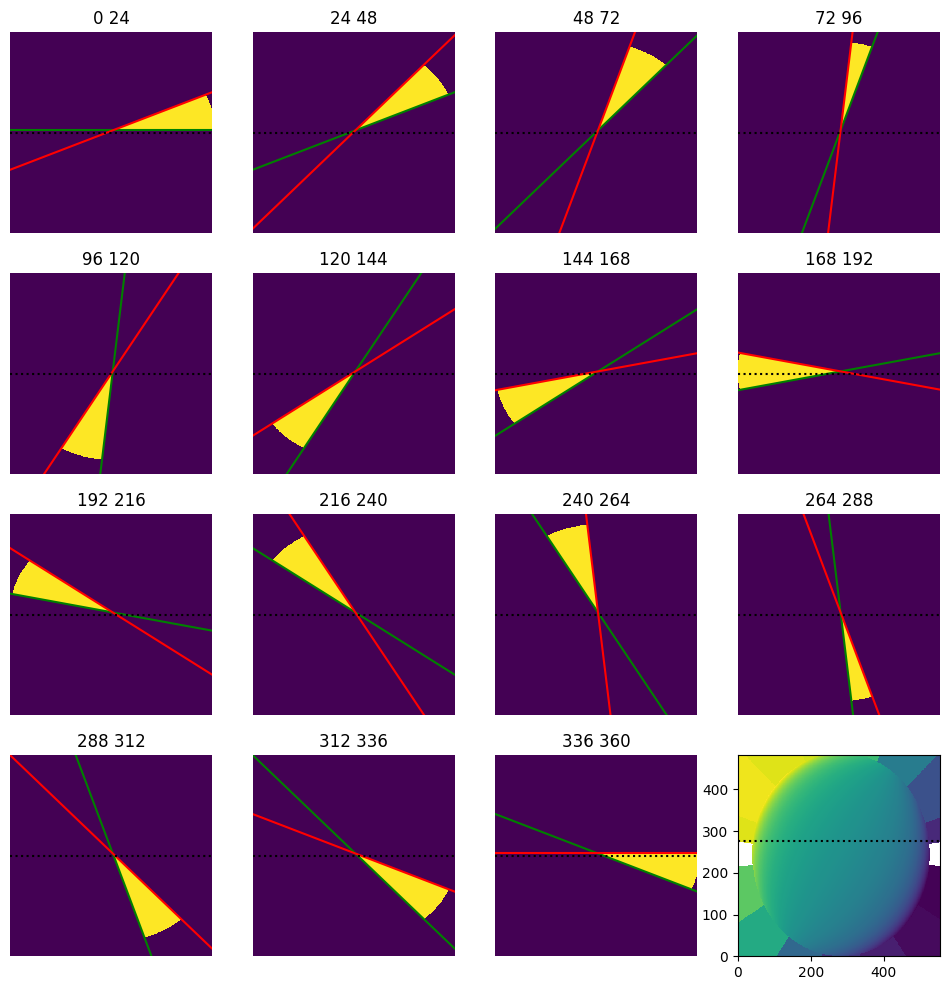

In [7]:
fig, bx = plt.subplots(4, 4, figsize=(12, 12))

skymap_cleaner = Clean_Skymap(asi.skymap['lon'], asi.skymap['lat'], asi.skymap['el'], min_elevation=10)
new_lon_grid, new_lat_grid = skymap_cleaner.remove_nans(ax=bx)
bx[-1, -1].pcolormesh(new_lon_grid)

for ax_i in bx.flatten()[:-1]:
    ax_i.axis("off")
for ax_i in bx.flatten():
    ax_i.axhline(new_lon_grid.shape[1]//2, c='k', ls=':')

lon grid (min, max) = (nan, nan)
lat grid (min, max) = (nan, nan)


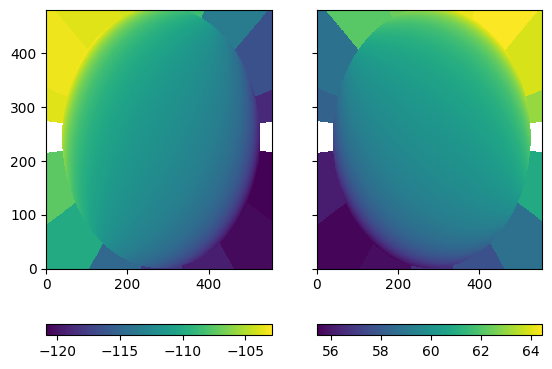

In [8]:
fig, cx = plt.subplots(1, 2, sharex=True, sharey=True)
p0 = cx[0].pcolormesh(new_lon_grid)
plt.colorbar(p0, orientation='horizontal')
p1 = cx[1].pcolormesh(new_lat_grid)
plt.colorbar(p1, orientation='horizontal')
print(f'lon grid (min, max) = ({new_lon_grid.min()}, {new_lon_grid.max()})')
print(f'lat grid (min, max) = ({new_lat_grid.min()}, {new_lat_grid.max()})')

In [37]:
angles

array([0.        , 0.26221605, 0.52443211, 0.78664816, 1.04886422,
       1.31108027, 1.57329633, 1.83551238, 2.09772844, 2.35994449,
       2.62216054, 2.8843766 , 3.14659265, 3.40880871, 3.67102476,
       3.93324082, 4.19545687, 4.45767293, 4.71988898, 4.98210503,
       5.24432109, 5.50653714, 5.7687532 , 6.03096925, 6.29318531])

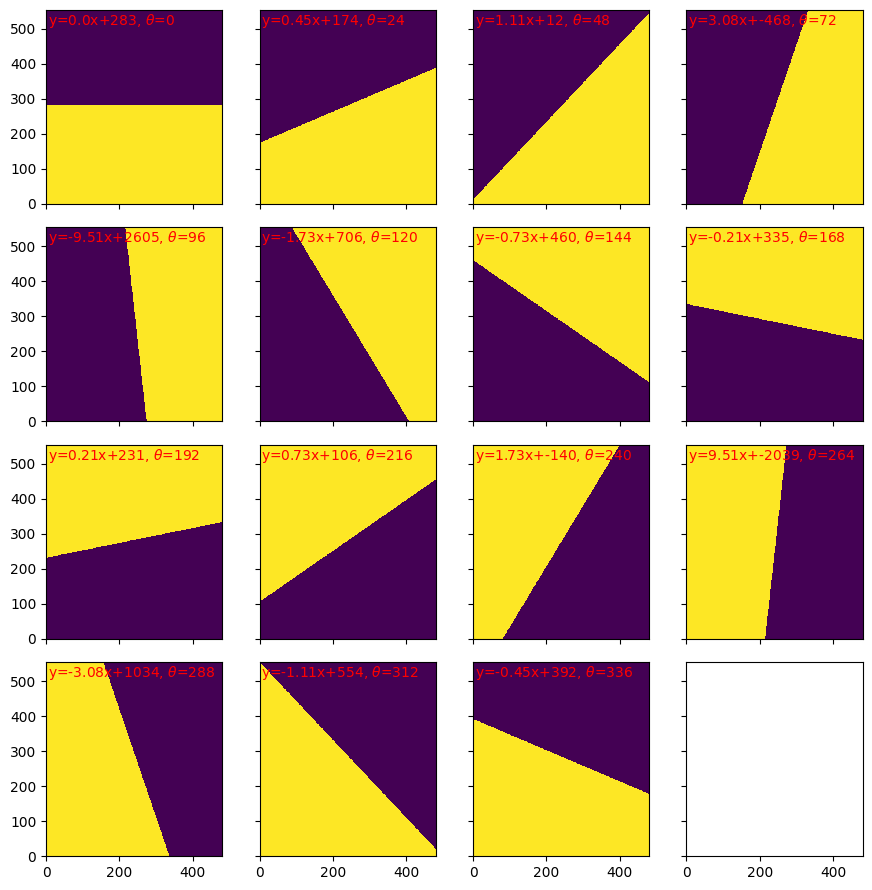

In [51]:
num=16
angles = np.linspace(0, 2*np.pi, num=num)
# We need to set up 2 sets of grids since U Calgary's (lat, lon) skymap
# dimentions are 1 greater than the (elevation, azimuth) skymaps.
xx_geodetic, yy_geodetic = np.meshgrid(
    np.arange(asi.skymap['lon'].shape[0]), 
    np.arange(asi.skymap['lon'].shape[1]), 
    # indexing='ij'  # So that the shapes of x, y, xx, and yy are the same.
    )
center_index = np.unravel_index(np.nanargmax(asi.skymap['el']), asi.skymap['el'].shape)
fig, ax = plt.subplots(np.sqrt(num).astype(int), np.sqrt(num).astype(int), sharex=True, sharey=True, figsize=(9, 9))

for i, (ax_i, start_angle, end_angle) in enumerate(zip(ax.flatten(), angles[:-1], angles[1:])):
    start_slope = np.tan(start_angle)
    start_y_int = center_index[1] - start_slope*center_index[0]

    if (start_angle < np.pi/2) or (start_angle > 3*np.pi/2):
        _op = operator.le
    else:
        _op = operator.ge
    idx = np.where(
        _op(yy_geodetic, start_slope*xx_geodetic + start_y_int)
    )
    mask = np.zeros_like(yy_geodetic)
    mask[idx] = 1
    ax_i.pcolormesh(mask)
    ax_i.text(
        0.01, 
        0.99, 
        f'y={round(start_slope, 2)}x+{round(start_y_int)}, $\\theta$={round(start_angle*180/np.pi)}',
        va='top',
        transform=ax_i.transAxes,
        color='red'
        )
plt.tight_layout()

In [50]:
center_index

(445, 99)